### ACEA WATER ANALYSIS

In [46]:
import pandas as pd
import numpy as np
# %matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from statsmodels.tsa.stattools import ccf
from scipy import stats

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-muted')
plt.rcParams['font.family'] = 'Arial'

In [47]:
# Preprocessing functions

def preprocess(df, col_ind, start_ind=0):
    """
    Some basic preprocessing of data from selected column of dataframe.
    This will probably need to be thought about more to deal with NaNs
    more effectively
    
    """
    pd_series = df.iloc[start_ind:, col_ind]
    pd_values = pd_series.to_numpy()
    # max_value = np.max(np.abs(pd_values))
    # pd_values = pd_values / max_value
    name = df.columns[col_ind]
    
    return pd_values, name


def preprocess_int(df, col_ind, start_ind=0):
    """
    Some basic preprocessing of data from selected column of dataframe.
    This will probably need to be thought about more to deal with NaNs
    more effectively
    
    """
    pd_series = df.iloc[start_ind:, col_ind]
    pd_series = pd_series.interpolate(method='linear')
    pd_series = pd_series.fillna(0)
    pd_values = pd_series.to_numpy()
    # max_value = np.max(np.abs(pd_values))
    # pd_values = pd_values / max_value
    name = df.columns[col_ind]
    
    return pd_values, name


def normalise_sum(signal):
    """
    Normalises a signal so that the sum of all samples is unity.

    :param signal: An array of values representing the signal to be normalised.
    :returns: An array of values representing the normalised signal.

    """
    signal = np.asarray(signal, dtype=float)
    sum_ = np.sum(signal) if signal.any() else 1.

    return signal / sum_


def movingav(signal, winwidth, winfunc=None):
    """
    Calculates the moving average of a signal using chosen window function.

    :param signal: An array of values representing the signal to be smoothed.
    :param winwidth: The width of the smoothing window (number of samples).
    :param winfunc: The window function to use for smoothing. By default, a
        rectangular window will be used.
    :returns: An array of values representing the smoothed signal.
    :raises ValueError: If window width is negative.
    :raises ValueError: If window width exceeds length of input array.

    """
    numsamples = len(signal)

    hww = int(winwidth / 2.)
    winwidth = 2 * hww + 1

    if winwidth < 0:
        raise ValueError("window width must not be negative")

    if winwidth >= numsamples:
        raise ValueError("window width must not exceed length of input array")

    win = np.ones(winwidth) if winfunc is None else winfunc(winwidth)

    win = normalise_sum(win)

    halfwin2 = normalise_sum(win[hww:])
    halfwin1 = normalise_sum(win[:hww+1])

    valstart = np.dot(halfwin2, signal[0:hww+1])
    valend = np.dot(halfwin1, signal[numsamples - hww - 1:])

    signal = np.concatenate((np.ones(hww) * valstart, signal,
                             np.ones(hww) * valend))

    wpos = hww
    wend = len(signal) - hww - 1

    sig_smooth = np.empty(numsamples)

    while wpos <= wend:
        sig_smooth[wpos - hww] = np.dot(signal[wpos-hww: wpos+hww+1], win)
        wpos += 1

    return sig_smooth

In [48]:
# Statistical functions 

def spearman_lag(data1, data2, lag):
    """Calculate Spearman's rank correlation coefficient between 2 datasets,
    with a lag applied to data2"""
    
    data_length = data1.size
    if lag > 0:
        data2_lag = np.zeros(data_length)
        data2_lag[lag:] = data2[:-lag] 
        data2_lag[:lag] = data2[0]
    else:
        data2_lag = data2
    src, _ = stats.spearmanr(data1, data2_lag)
    
    return src


def cross_corr_lag(data1, data2, lag_array=None):
    """Calculate Spearman's rank correlation coefficient between 2 datasets,
    for a range of different lags applied to data2"""
    if lag_array is None:
        lag_array = np.arange(data1.size)
    crosscorr_lag = np.empty(len(lag_array))
    for n in range(len(lag_array)):
        crosscorr_lag[n] = spearman_lag(data1, data2, lag=lag_array[n])
        
    return crosscorr_lag, lag_array


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def normalise_0_to_1(signal):
    sig_min = np.min(signal)
    sig_max = np.max(signal)
    sig_norm = (signal - sig_min) / (sig_max - sig_min)
    return sig_norm


def find_datatypes(df):
    """Find the indices of each pf the different datatypes in the dataframe"""
    names = df.columns
    datatypes = ['Rainfall',
                 'Depth_to_Groundwater',
                 'Temperature',
                 'Volume',
                 'Hydrometry',
                 'Flow_rate',
                 'Lake_level']
    col_inds = []
    
    for n in range(len(datatypes)):
        col_ind_type = []
        for c in range(len(names)):
            if datatypes[n] in names[c]:
                col_ind_type.append(c)
        col_inds.append(col_ind_type)
        
    return datatypes, col_inds

In [49]:
# Plotting functions 

def plot_data_preprocessed(df, col_ind):
    data_ts, _ = preprocess(df, col_ind)
    data_ts_int, _ = preprocess_int(df, col_ind)
    data_ts_size = data_ts.size
    data_ts_int_size = data_ts_int.size
    time_array = np.linspace(0, data_ts_size-1, data_ts_size)
    time_array2 = np.linspace(0, data_ts_int_size-1, data_ts_int_size)
    plt.figure()
    plt.scatter(time_array, data_ts, s=0.2, alpha=0.6)
    plt.scatter(time_array2, data_ts_int, s=0.2, alpha=0.6)
    plt.show()

In [50]:
# tau analysis functions 


def tau_and_lag_correl(target_ts, rain_ts, lag_array=None, tau_array=None,
                       plot=True):
    """
    Calculate correlation coefficients for different time lag and tau
    values for rainfall. Optional plot.

    """
    # Set default lag and tau values to analyse
    if lag_array is None:
        lag_array = np.arange(20)
    if tau_array is None:
        tau_array = np.linspace(22, 90, 35).astype(np.int)
        
    # Calculate Spearman's Rank coefficient for each tau and lag combination
    sp_rank_cc = []
    for n in range(len(lag_array)):
        lag = lag_array[n]
        data_length = rain_ts.size
        if lag > 0:
            data_lag = np.zeros(data_length)
            data_lag[lag:] = rain_ts[:-lag]
            data_lag[:lag] = rain_ts[0]
        else:
            data_lag = rain_ts
        src, _ = find_tau_correlation(target_ts, data_lag,
                                      tau_array=tau_array)
        sp_rank_cc.append(src)
    sp_rank_cc = np.asarray(sp_rank_cc)
    
    # Plot matrix showing correlation for each tau and lag combination
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(sp_rank_cc)
        fig.colorbar(cax)
        ax.set_xticks(np.arange(len(tau_array)))
        ax.set_yticks(np.arange(len(lag_array)))
        ax.set_xticklabels(tau_array)
        ax.set_yticklabels(lag_array)
        ax.xaxis.set_ticks_position('bottom')
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
                 rotation_mode="anchor")
        ax.set_xlabel('Tau for exponential window')
        ax.set_ylabel('Time lag [days]')
        plt.title('Correlation of rainfall with target for different values of tau and time lag')
        fig.show()
        
    return sp_rank_cc, lag_array, tau_array

In [51]:
# LSTM functions 

def create_dataset(dataset, look_back=1, chunk_step=1, predict_steps=1):
    """
    Convert data set into a dataset matrix by splitting the data into a number of 'chunks'
    that are randomly ordered. Each chunk has an input (x) of length 'look_back', and an
    output (y) of length 'predict_steps'. The indices of each chunk within the original array
    are stored in 'y_ind'.
    The shape of the input and output arrays is as follows:
    dataset: (num features, num timesteps)
    x:       (num chunks, look_back, num features)
    y:       (num chunks, predict_steps)
    y_ind:   (num chunks)
    
    """
    numchunk = int(np.floor((dataset.shape[1] - look_back - 1) / chunk_step))
    dataX = np.empty((numchunk, look_back, dataset.shape[0]))
    dataY = np.empty((numchunk, predict_steps))
    y_ind = []
    
    # Create chunks of data with the specified look back
    for i in range(numchunk):
        start_ind = chunk_step*i
        dataX[i, :, :] = dataset[:, start_ind:(start_ind + look_back)].T
        dataY[i, :] = dataset[0,start_ind+look_back:start_ind+look_back+predict_steps] #MG
        #dataY.append(dataset[0, start_ind + look_back])
        y_ind.append(start_ind + look_back)
        
    # Randomise order of chunks
    rand_indices = np.random.permutation(numchunk)
    x = np.array(dataX)
    y = np.array(dataY)
    y_ind = np.array(y_ind)
    x = x[rand_indices, :]
    y = y[rand_indices,:]
    #y = np.reshape(y, (y.size, 1)) # MG
    y_ind = y_ind[rand_indices]
    
    return x, y, y_ind

## Data pre-processing



In [52]:
# Preprocessing data

# Importing all data
foldpath = r"acea-water-prediction"
files = list(Path(foldpath).rglob('*.csv'))
df = pd.read_csv(files[0]) # Create dataframe

# Get time series data for target variable and some other variables
# Specified by column index of the pandas dataframe
datatypes, col_inds = find_datatypes(df)
col_ind_target = 13
col_targets = col_inds[1]
col_ind_others = [1, 15, 16]
col_rain = col_inds[0]
col_vol = col_inds[3]

# Get target time series data
target_ts, target_name = preprocess_int(df, col_ind_target, start_ind=3955)
target_length = target_ts.size

# Get time series data for all targets
all_target_ts = []
all_target_name = []
for n in range(len(col_targets)):
    ts_, name_ = preprocess_int(df, col_targets[n], start_ind=3955)
    all_target_ts.append(ts_)
    all_target_name.append(name_)    

In [53]:
# Get time series data for all rain variables
rain_ts = []
rain_name = []
for n in range(len(col_rain)):
    ts_, name_ = preprocess_int(df, col_rain[n], start_ind=3955)
    rain_ts.append(ts_)
    rain_name.append(name_)
    
# Get time series data for all volume variables
vol_ts = []
vol_name = []
for n in range(len(col_vol)):
    ts_, name_ = preprocess_int(df, col_vol[n], start_ind=3955)
    vol_ts.append(ts_)
    vol_name.append(name_)

### Handling gaps & anomalies


In [54]:
# Remove zeros from target
# N.B. SHOULD REPLACE THIS WITH A DIFFERENT METHOD
for m in range(len(all_target_ts)):
    for n in range(len(all_target_ts[m])):
        if n > 0 and all_target_ts[m][n] == 0:
            all_target_ts[m][n] = all_target_ts[m][n-1]

### Rainfall
Rainfall was expected to be one of the most useful variables in predicting groundwater levels, since it is one the key physical mechanisms that drives the inflow of water into aquifiers. From a visual inspection of the data, it was clear that many of the peaks in rainfall correspond approximately to peaks in the groundwater level. This was seen to apply both to the longer term trend, as well as on a smaller day-by-day scale. However, while the peaks in rainfall are often immediately followed by days of zero rainfall, the peaks in the groundwater data seem to decay more slowly over time.

This led to the hypothesis that the rainfall on a particular day adds to the groundwater level relatively quickly, and then this level decays more slowly over several weeks. The physical explanation for this seems to be logical - if the rate of the rainfall is significantly larger than the rate that the water drains out of the groundwater subsystem, then the level will rise quickly and fall slowly (similar to the level of a slowly leaking cup when water is poured into it). For shallower subsystems, we may expect to see more short term reactions to the rainfall, as it would reach the subsystem more quickly and drain out more quickly; and conversely for deeper subsystems, we would expect the levels to react more slowly, with smaller short term effects.

To test this hypothesis, the rainfall data was convolved with an exponential window function, for a range of different time constants. The correlation of these convolved signals with the 'depth to groundwater' variables was calculated to find the time constant that gave the best correlation for each combination of variables.

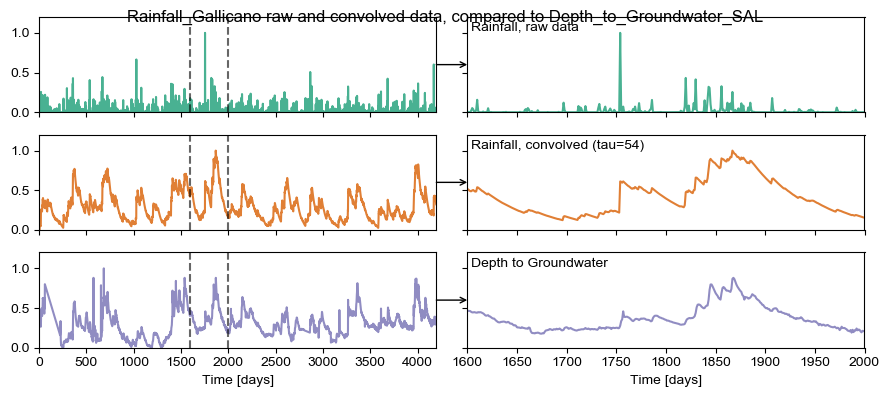

In [55]:
# Rainfall data analysis

def exp_convolve(data, tau, winlength=None):
    """
    Convolve input data with an exponential window function (time constant = tau)
    
    """
    data = np.asarray(data)
    len_data = data.size
    if winlength is None:
        winlength = len_data
    t = np.linspace(0, winlength-1, winlength)
    exp_window = np.exp(-t / tau)
    exp_window = exp_window / np.sum(exp_window)
    data_conv = np.convolve(data, exp_window, 'full')[:len_data]

    return data_conv


def plot_rainfall_conv_comparison(rain_ind, target_ind, tau, rain_name, target_name,
                                  crop_min=1600, crop_max=2000):
    """
    Plot example of rainfall raw data compared to rainfall convolved with exponential window
    
    """
    rain_example = rain_ts[rain_ind]
    rain_conv_example = exp_convolve(rain_example, tau=tau)
    cmap = plt.get_cmap('Dark2')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]
    len_data = rain_example.size
    fig, ax = plt.subplots(3, 2, sharey=True, figsize=(9, 4))
    y_max = 1.2
    
    ax[1, 0].set_ylim(0, y_max)
    ax[0, 0].plot(normalise_0_to_1(rain_example), color=colors[0], alpha=0.8)
    ax[1, 0].plot(normalise_0_to_1(rain_conv_example), color=colors[1], alpha=0.8)
    ax[2, 0].plot(normalise_0_to_1(all_target_ts[target_ind]), color=colors[2], alpha=0.8)
    ax[0, 1].text(0.01, 0.95, 'Rainfall, raw data', transform=ax[0, 1].transAxes, va='top', ha='left')
    ax[1, 1].text(0.01, 0.95, 'Rainfall, convolved (tau={})'.format(np.int(tau)),
                  transform=ax[1, 1].transAxes, va='top', ha='left')
    ax[2, 1].text(0.01, 0.95, 'Depth to Groundwater', transform=ax[2, 1].transAxes, va='top', ha='left')
    
    xmin = crop_min
    xmax = crop_max
    for n in range(3):
        ax[n, 0].plot([xmin, xmin], [0, y_max], 'k--', alpha=0.6)
        ax[n, 0].plot([xmax, xmax], [0, y_max], 'k--', alpha=0.6)
        ax[n, 0].set_xlim(0, len_data)
        ax[n, 1].set_xlim(xmin, xmax)
        con = mpl.patches.ConnectionPatch(xyA=[len_data, y_max/2], coordsA=ax[n, 0].transData,
                                          xyB=[xmin, y_max/2], coordsB=ax[n, 1].transData,
                                          arrowstyle='->')
        fig.add_artist(con)
        
    days = np.arange(xmin, xmax) 
    ax[0, 1].plot(days, normalise_0_to_1(rain_example)[xmin: xmax], color=colors[0], alpha=0.8)
    ax[1, 1].plot(days, normalise_0_to_1(rain_conv_example)[xmin: xmax], color=colors[1], alpha=0.8)
    ax[2, 1].plot(days, normalise_0_to_1(all_target_ts[target_ind])[xmin: xmax], color=colors[2], alpha=0.8)
    
    for n in range(2):
        ax[n, 0].axes.xaxis.set_ticklabels([])
        ax[n, 1].axes.xaxis.set_ticklabels([])
        ax[2, n].set_xlabel('Time [days]')
        
    plot_title = rain_name[rain_ind] + ' raw and convolved data, compared to ' + all_target_name[target_ind]
    fig.suptitle(plot_title)
    plt.tight_layout()
    plt.show()
    
    return


plot_rainfall_conv_comparison(rain_ind=0, target_ind=1, tau=54, rain_name=rain_name,
                              target_name=all_target_name,
                              crop_min=1600, crop_max=2000)

# plot_rainfall_conv_comparison(rain_ind=0, target_ind=0, tau=1120, rain_name=rain_name,
#                               target_name=all_target_name,
#                               crop_min=500, crop_max=2000)

plt.show()

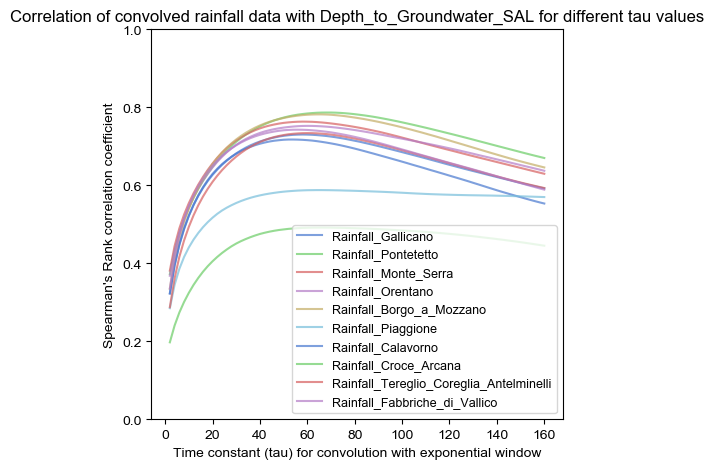

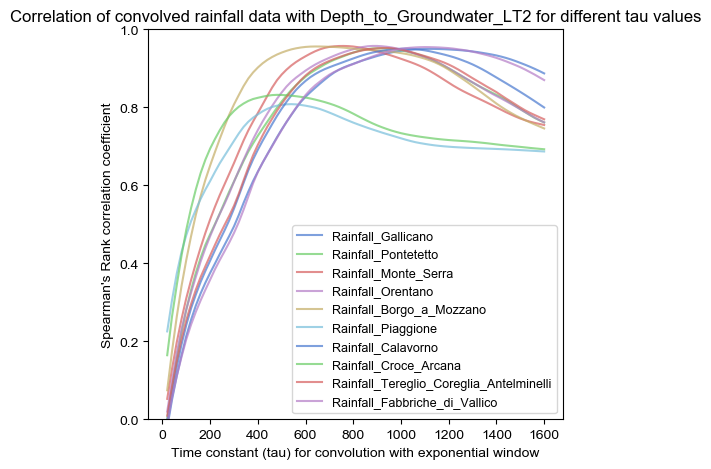

In [56]:
# Plot example of correlation for different tau values

def find_tau_correlation(target_ts, rain_ts, tau_array=None):
    """
    Calculate convolution of rainfall data with an exponential window
    with time constant tau, for a range of values of tau.
    Then determine how correlated these convolved signals are to the
    target data by calculating Spearman's rank correlation coefficient
    for each value of tau
    
    """
    if tau_array is None:
        tau_array = np.linspace(2, 120, 60)
        
    rain_ts = np.asarray(rain_ts)
    target_ts = np.asarray(target_ts)
    winlength = rain_ts.size
    target_len = target_ts.size
    
    t = np.linspace(0, winlength-1, winlength)
    src = np.empty(len(tau_array))
    
    for n in range(len(tau_array)):
        exp_win = np.exp(-t/tau_array[n])
        rain_conv = np.convolve(rain_ts, exp_win, 'full')[:target_len]
        rain_conv = rain_conv / np.sum(exp_win)
        # if n==40:
        #     plt.figure()
        #     plt.plot(rain_ts, label='rain_ts')
        #     plt.plot(rain_conv, label='rain_conv')
        #     plt.plot(target_ts, label='target_ts')
        #     plt.legend()
        #     plt.show()
        src[n], _ = stats.spearmanr(target_ts, rain_conv)
        
    return src, tau_array


def find_best_tau(target_ts, rain_ts, plot=True, rain_name=None, target_name=None, tau_array=None):
    """
    Calculate correlation of convolved rainfall signal with the
    target signal for different time constants of exponential window
    and select the tau value that gives the best correlation.
    Optional plot of correlation for different tau values.
    
    """
    tau_best = []
    if plot: plt.figure()
    for n in range(len(rain_ts)):
        src, tau_array = find_tau_correlation(
                                normalise_0_to_1(target_ts),
                                normalise_0_to_1(rain_ts[n]),
                                tau_array=tau_array)
        tau_best.append(tau_array[np.argmax(src)])
        if plot: plt.plot(tau_array, src, label=rain_name[n], lw=1.5, alpha=0.7)  
            
    if plot:
        plt.xlabel("Time constant (tau) for convolution with exponential window")
        plt.ylabel("Spearman's Rank correlation coefficient")
        title_text = 'Correlation of convolved rainfall data with {} for different tau values'.format(target_name)
        plt.title(title_text, wrap=True)
        plt.ylim(0, 1)
        plt.legend(fontsize=9)
        plt.tight_layout()
        plt.show()
        
    return tau_best


tau_best = find_best_tau(target_ts=all_target_ts[1], rain_ts=rain_ts,
                         rain_name=rain_name, plot=True,
                         target_name=all_target_name[1],
                         tau_array=np.linspace(2, 160, 80))

tau_best = find_best_tau(target_ts=all_target_ts[0], rain_ts=rain_ts, plot=True,
                         target_name=all_target_name[0],
                         rain_name=rain_name,
                         tau_array=np.linspace(20, 1600, 80))


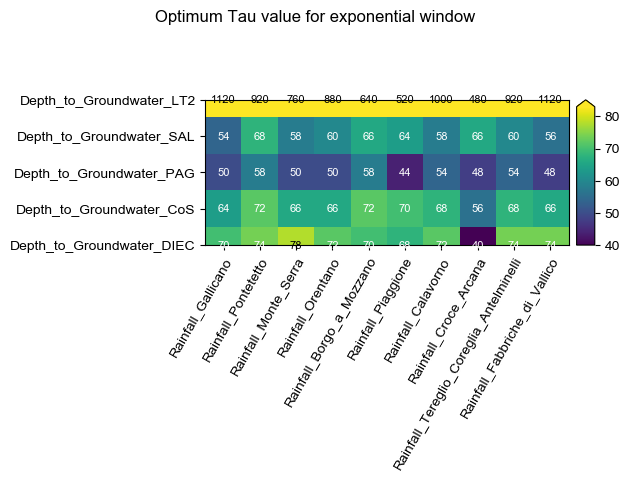

In [57]:
# Calculating optimum tau for each rainfall/target combination that
# maximises the Spearman's Rank correlation coefficient

all_tau_best = []
for n in range(len(all_target_ts)):
    if n == 0:
        tau_array = np.linspace(240, 2200, 50)
    else:
        tau_array = None
    tau_best = find_best_tau(all_target_ts[n], rain_ts, plot=False,
                             tau_array=tau_array)
    all_tau_best.append(tau_best)
all_tau_best = np.asarray(all_tau_best)

# Plot results
fig = plt.figure()
ax = plt.subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)
cbar_min = np.min(all_tau_best)
cbar_max = np.max(all_tau_best[1:, :]) + 5
norm = mpl.colors.Normalize(vmin=cbar_min, vmax=cbar_max)
sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
ms = ax.imshow(all_tau_best, norm=norm, cmap='viridis')
for i in range(len(all_target_name)):
    for j in range(len(rain_name)):
        if (cbar_max - all_tau_best[i, j]) / (cbar_max - cbar_min) < 0.2:
            text_col = 'k'
        else:
            text_col = 'w'
        text = ax.text(j, i, np.int(all_tau_best[i, j]),
                       ha="center", va="center", color=text_col,
                       fontsize=8)
fig.suptitle('Optimum Tau value for exponential window')
ax.set_xticks(np.arange(len(rain_name)))
ax.set_yticks(np.arange(len(all_target_name)))
ax.set_xticklabels(rain_name)
ax.set_yticklabels(all_target_name)
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.colorbar(mappable=sc_map, cax=cax, extend='max')
plt.tight_layout()
plt.show()


In [58]:
# Rainfall data preprocessing
target_ind = 1
tau_best = find_best_tau(all_target_ts[target_ind], rain_ts, plot=False,
                         rain_name=rain_name)
rain_conv = []
for n in range(len(rain_ts)):
    conv = exp_convolve(rain_ts[n], tau_best[n])
    rain_conv.append(conv)

### Volume
Initial inspection of the 'volume' data showed the following:
- There is a relatively strong weekly pattern, and typically step changes every month. These are presumably linked to human activity/demand, and similar patterns are not clearly visible in the 'depth to groundwater' target variables. This suggests that it may be helpful to apply some smoothing to the volume data prior to modelling, in order to reduce the effect of the weekly/monthly variation.
- There are some very long timescale trends in the ampltidue, for example both Volume_CC1 and Volume_CC2 both increase gradually over the whole time period of the data. This timescale of change (perhaps linked to human activity/demand changes) is not present in the depth to groundwater variables, so there may be some benefit in removing it from the volume data prior to modelling.

In order to try to make the volume data more useful for modelling depth to groundwater, the following pre-processing was proposed based on the findings above:
- Caclulate the deviation of the volume data from a smoothed version of the data. The smoothed version of the data should be created with a relatively long smoothing window so that it represents the long term trend of the volume data.
- Apply some smoothing to the deviation calculated above, with a relatively short smoothing window, in order to reduce the effect of the weekly/monthly variation.

In [59]:
# Plot all volume data - for reference, not for final notebook

# plt.figure()
# for n in range(len(vol_ts)):
#     plt.plot(vol_ts[n], label=vol_name[n])
# plt.legend()
# plt.show()
    

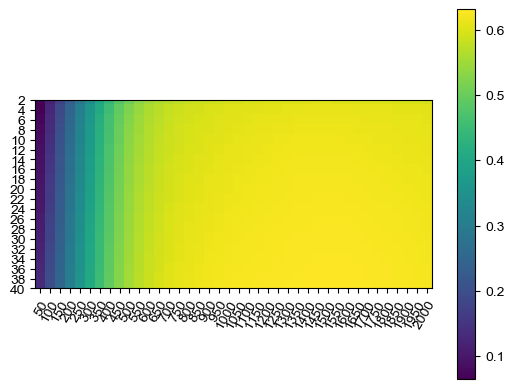

In [60]:
# Volume pre-processing

def preprocess_vol(vol_data, smooth_amt_1=800, smooth_amt_2=30):
    """Pre-process volume data by smoothing, calculating deviation from the smoothed data,
    and then smoothing again"""
    deviation = vol_data - movingav(vol_data, smooth_amt_1, winfunc=np.hanning)
    smoothed = movingav(deviation, smooth_amt_2, winfunc=np.hanning)
    return normalise_0_to_1(smoothed)
    

def find_best_vol_params(vol_ts, target_ts, smoothing_1=None, smoothing_2=None, plot=True):
    """Calculate the correlation of the preprocessed volume data with the target data for
    different lengths of smoothing window, in order to find the most appropropriate settings"""
    if smoothing_1 is None:
        smoothing_1 = np.linspace(50, 2000, 40).astype(np.int)
    if smoothing_2 is None:
        smoothing_2 = np.linspace(2, 40, 20).astype(np.int)
    num_smth_1 = smoothing_1.size
    num_smth_2 = smoothing_2.size
    coeffs = np.empty((num_smth_1, num_smth_2))
    for i in range(num_smth_1):
        for j in range(num_smth_2):
            vol_processed = preprocess_vol(vol_ts, smooth_amt_1=smoothing_1[i],
                                           smooth_amt_2=smoothing_2[j])
            corr_coeff, _ = stats.spearmanr(vol_processed, target_ts)
            coeffs[i, j] = corr_coeff
    
    if plot:
        plt.figure()
        ax = plt.subplot(111)
        im = ax.imshow(coeffs.T)
#         norm = mpl.colors.Normalize(vmin=0, vmax=1)
#         sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
#         plt.colorbar(mappable=sc_map)
        ax.figure.colorbar(im, ax=ax)
        ax.set_xticks(np.arange(num_smth_1))
        ax.set_yticks(np.arange(num_smth_2))
        ax.set_xticklabels(smoothing_1)
        ax.set_yticklabels(smoothing_2)
        ax.xaxis.set_ticks_position('bottom')
        plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
                 rotation_mode="anchor")
        plt.show()
    return
    
# Not sure if we need this in the notebook? Could get rid of it or stick it in the appendix and just
# say in the main text that we chose the most appropriate smoothing values.

find_best_vol_params(vol_ts[0], np.sum(all_target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)
# find_best_vol_params(vol_ts[0], np.sum(all_target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)
# find_best_vol_params(vol_ts[1], np.sum(all_target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)
# find_best_vol_params(vol_ts[2], np.sum(all_target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)


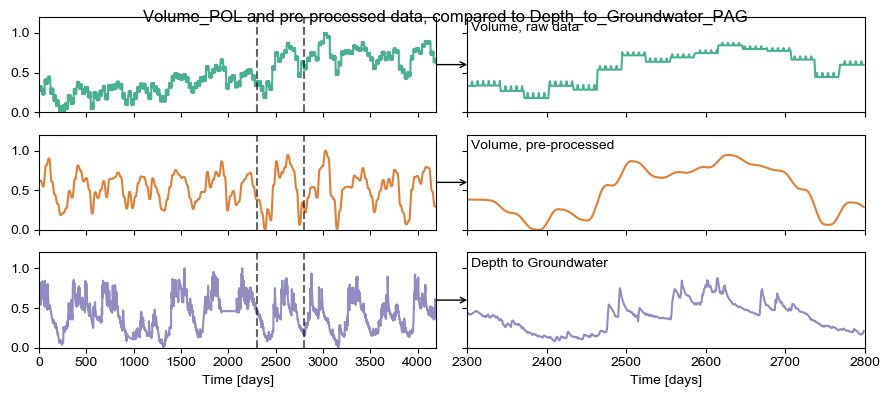

In [61]:
# Plot comparing original and pre-processed volume data

def plot_volume_preprocess(vol_ind, target_ind, vol_name, all_target_name,
                           smooth_1=None, smooth_2=None, crop_min=2300, crop_max=2800):
    """
    Plot example of volume raw data compared to preprocessed data and target
    
    """
    vol_example = vol_ts[vol_ind]
    if smooth_1 is None and smooth_2 is None:
        vol_pp = preprocess_vol(vol_example)
    elif smooth_1 is None and smooth_2 is not None:
        vol_pp = preprocess_vol(vol_example, smooth_amt_2=smooth_2)
    elif smooth_1 is not None and smooth_2 is None:
        vol_pp = preprocess_vol(vol_example, smooth_amt_1=smooth_1)
    else:
        vol_pp = preprocess_vol(vol_example, smooth_amt_1=smooth_1, smooth_amt_2=smooth_2)
    cmap = plt.get_cmap('Dark2')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]
    len_data = vol_example.size
    fig, ax = plt.subplots(3, 2, sharey=True, figsize=(9, 4))
    y_max = 1.2
    
    ax[1, 0].set_ylim(0, y_max)
    ax[0, 0].plot(normalise_0_to_1(vol_example), color=colors[0], alpha=0.8)
    ax[1, 0].plot(normalise_0_to_1(vol_pp), color=colors[1], alpha=0.8)
    ax[2, 0].plot(normalise_0_to_1(all_target_ts[target_ind]), color=colors[2], alpha=0.8)
    ax[0, 1].text(0.01, 0.95, 'Volume, raw data', transform=ax[0, 1].transAxes, va='top', ha='left')
    ax[1, 1].text(0.01, 0.95, 'Volume, pre-processed', transform=ax[1, 1].transAxes, va='top', ha='left')
    ax[2, 1].text(0.01, 0.95, 'Depth to Groundwater', transform=ax[2, 1].transAxes, va='top', ha='left')
    
    xmin = crop_min
    xmax = crop_max
    for n in range(3):
        ax[n, 0].plot([xmin, xmin], [0, y_max], 'k--', alpha=0.6)
        ax[n, 0].plot([xmax, xmax], [0, y_max], 'k--', alpha=0.6)
        ax[n, 0].set_xlim(0, len_data)
        ax[n, 1].set_xlim(xmin, xmax)
        con = mpl.patches.ConnectionPatch(xyA=[len_data, y_max/2], coordsA=ax[n, 0].transData,
                                          xyB=[xmin, y_max/2], coordsB=ax[n, 1].transData,
                                          arrowstyle='->')
        fig.add_artist(con)
        
    days = np.arange(xmin, xmax) 
    ax[0, 1].plot(days, normalise_0_to_1(vol_example)[xmin: xmax], color=colors[0], alpha=0.8)
    ax[1, 1].plot(days, normalise_0_to_1(vol_pp)[xmin: xmax], color=colors[1], alpha=0.8)
    ax[2, 1].plot(days, normalise_0_to_1(all_target_ts[target_ind])[xmin: xmax], color=colors[2], alpha=0.8)
    
    for n in range(2):
        ax[n, 0].axes.xaxis.set_ticklabels([])
        ax[n, 1].axes.xaxis.set_ticklabels([])
        ax[2, n].set_xlabel('Time [days]')
        
    plot_title = vol_name[vol_ind] + ' and pre-processed data, compared to ' + all_target_name[target_ind]
    fig.suptitle(plot_title)
    plt.tight_layout()
    plt.show()
    
    return


plot_volume_preprocess(0, 2, vol_name, all_target_name,
                       smooth_1=None, smooth_2=None, crop_min=2300, crop_max=2800)


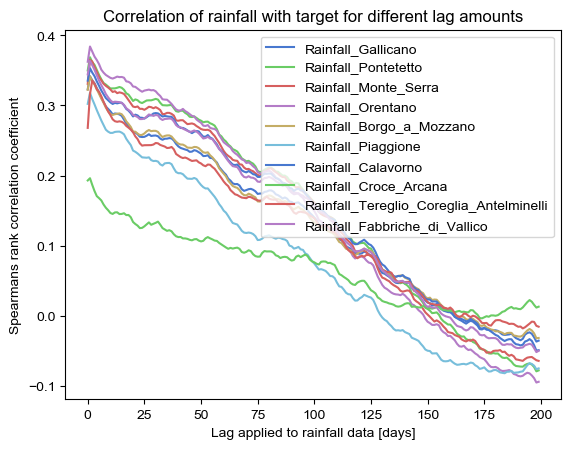

/Users/guptam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


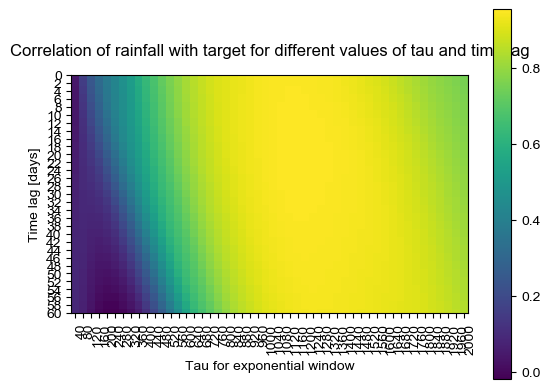

In [62]:
"""
Smoothing for deeper groundwater?
"""
# Analysis of how lag applied to rainfall affects correlation with target
lag_array = np.arange(200)
plt.figure()
for n in range(len(rain_ts)):
    crosscorr_lag, lag_array = cross_corr_lag(
                                    normalise_0_to_1(all_target_ts[2]),
                                    normalise_0_to_1(rain_ts[n]),
                                    lag_array=lag_array)
    plt.plot(lag_array, crosscorr_lag, label=rain_name[n])
plt.legend()
plt.xlabel('Lag applied to rainfall data [days]')
plt.ylabel('Spearman''s rank correlation coefficient')
plt.title('Correlation of rainfall with target for different lag amounts')
plt.show()

    

target_test_ind = 0
rain_test_ind = 0
# lag_array = np.arange(30)
# tau_array = np.linspace(12, 90, 40).astype(np.int)
lag_array = np.linspace(0, 60, 31).astype(np.int)
tau_array = np.linspace(40, 2000, 50).astype(np.int)
data1 = all_target_ts[target_test_ind]
data2 = rain_ts[rain_test_ind]
sp_rank_cc, lag_array, tau_array = tau_and_lag_correl(data1,
                                                      data2,
                                                      lag_array=lag_array,
                                                      tau_array=tau_array,
                                                      plot=True)

### Cross correlation

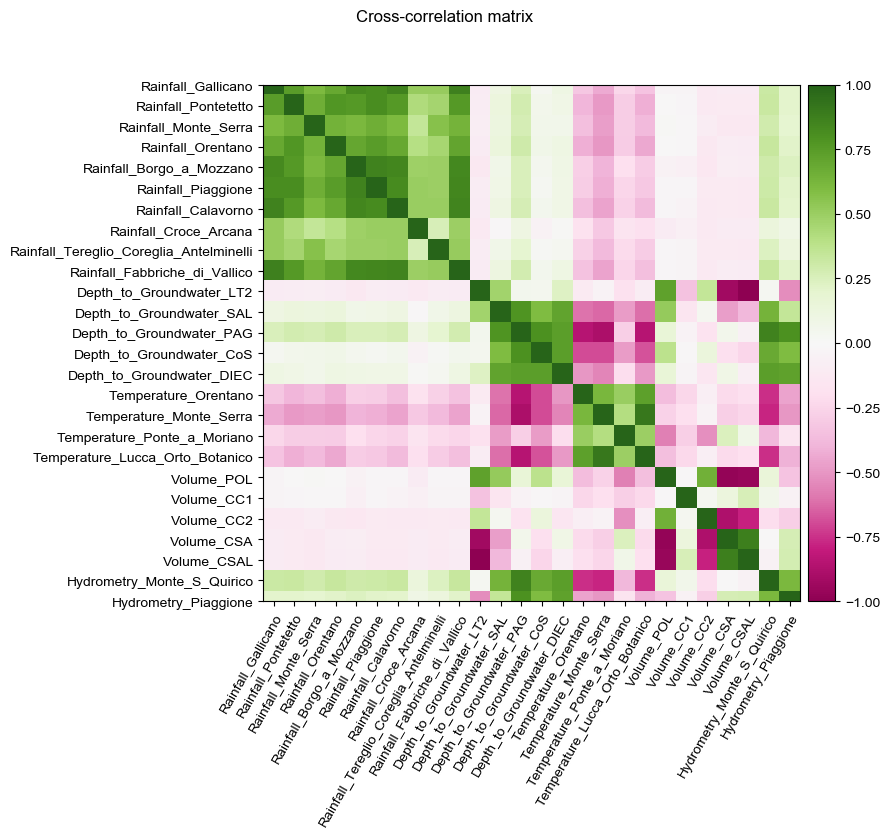

In [63]:
# Should probably do the preprocessing/missing values first, but for now just using raw data

# Put data into numpy array, ignoring date variable
df_nodate = df.drop(['Date'], axis=1)
all_data = df_nodate.to_numpy()
column_names = df_nodate.columns
numcol = len(column_names)

# Calculate cross-correlation
cross_corr, p_value = stats.spearmanr(all_data, nan_policy='omit')
    
# Plot results
fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='PiYG')
ms = ax.imshow(cross_corr, cmap='PiYG', interpolation='none')
fig.suptitle('Cross-correlation matrix')
ax.set_xticks(np.arange(numcol))
ax.set_yticks(np.arange(numcol))
ax.set_xticklabels(column_names)
ax.set_yticklabels(column_names)
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.colorbar(mappable=sc_map, cax=cax)
plt.tight_layout()
plt.show()

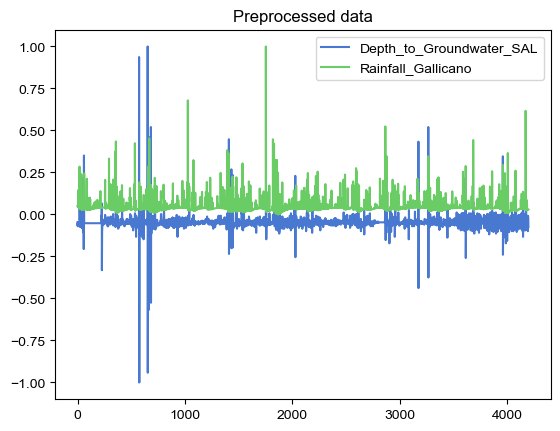

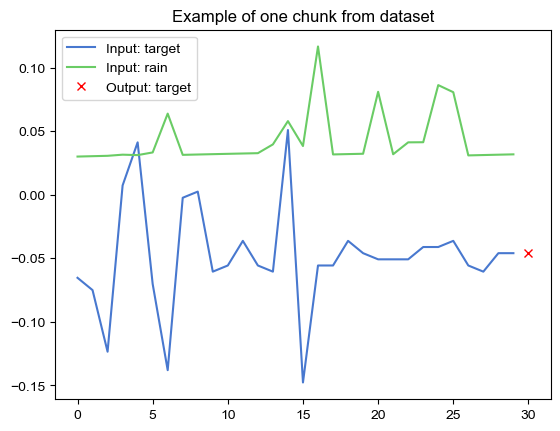

Epoch 1/30
11/11 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 2/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 3/30
11/11 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 4/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 5/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 6/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 7/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 8/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 9/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 10/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 11/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 12/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 13/30
11/11 [==============================

In [64]:
# LSTM analysis

# Model parameters
target_ind = 1
look_back = 30
chunk_step = 50
train_ratio = 0.67
num_epochs = 30
batch_size = 5
predict_steps = 15

# Fix random seed for reproducibility
np.random.seed(7)

# Calculate differential of target & rainfall
target_diff = np.diff(all_target_ts[target_ind])
rain_conv_diff = []
for n in range(len(rain_ts)):
    rain_conv_diff.append(np.diff(rain_conv[n]))

# Normalize the datasets
target_data = target_diff
all_target_ts[target_ind] = all_target_ts[target_ind][1:]
target_data = np.reshape(target_data, (target_data.size, 1))
scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaled = scaler.fit_transform(target_data)
target_scaled = np.squeeze(target_scaled)
rain_scaled = normalise_0_to_1(rain_conv_diff[0])

# Combine the dataset into single array
dataset = np.stack((target_scaled, rain_scaled))

# Plot presprocessed data
plt.figure()
plt.plot(dataset[0, :], label=all_target_name[target_ind])
plt.plot(dataset[1, :], label=rain_name[0])
plt.legend()
plt.title('Preprocessed data')
plt.show()

# Split data into chunks with random order
x, y, y_ind = create_dataset(dataset, look_back=look_back,
                             chunk_step=chunk_step,predict_steps=predict_steps)
numchunk = y.shape[0]

# split into train and test sets
train_size = int(numchunk * train_ratio)
test_size = numchunk - train_size
trainX, testX = x[0:train_size, :, :], x[train_size:numchunk, :, :]
trainY, testY = y[0:train_size, :], y[train_size:numchunk, :]
trainYind, testYind = y_ind[0:train_size], y_ind[train_size:numchunk]

# Plot one example of chunk
sample_num = 10
plt.figure()
time_ = np.arange(look_back)
plt.plot(time_, trainX[sample_num, :, 0], label='Input: target')
plt.plot(time_, trainX[sample_num, :, 1], label='Input: rain')
plt.plot([look_back], trainY[sample_num, 0], 'xr', label='Output: target')
plt.legend()
plt.title("Example of one chunk from dataset")
plt.show()

# create and fit the LSTM network
num_features = x.shape[2]
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, num_features)))
model.add(Dense(predict_steps))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=1)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

# Convert from diff to actual prediction
for n in range(train_size):
    prev_day = all_target_ts[target_ind][trainYind[n] - 1]
    trainY[n] = prev_day + trainY[n]
    trainPredict[n] = prev_day + trainPredict[n]
for n in range(test_size):
    prev_day = all_target_ts[target_ind][testYind[n] - 1]
    testY[n] = prev_day + testY[n]
    testPredict[n] = prev_day + testPredict[n]

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:, 0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


In [65]:
# # Plot one prediction example from test sample
# pred_sample = 4
# pred_ind = testYind[pred_sample]
# plt.figure()
# sample_t = np.linspace(pred_ind - look_back - 1, pred_ind - 1, look_back)
# sample_t = sample_t.astype(np.int)
# plt.plot(sample_t, all_target_ts[target_ind][sample_t[0]:sample_t[-1]])
# plt.plot(pred_ind, testPredict[pred_sample, 0], 'xr')
# plt.title("Example of one prediction from test data")
# plt.show()


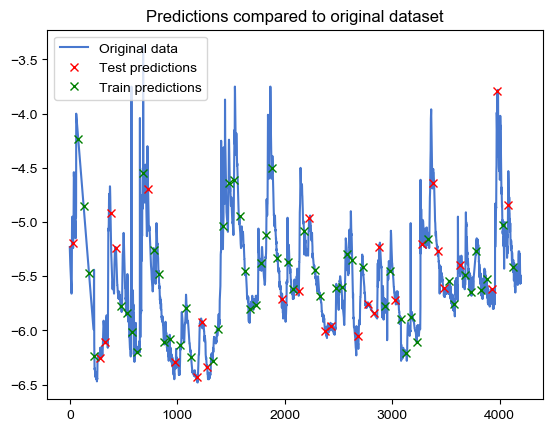

In [66]:
# Plot all predictions from test samples against original data
plt.figure()
plt.plot(np.linspace(0, all_target_ts[target_ind].size-1,
                     all_target_ts[target_ind].size),
         all_target_ts[target_ind],
         label='Original data')
plt.plot(testYind, testPredict[:, 0], 'xr', label='Test predictions')
plt.plot(trainYind, trainPredict[:, 0], 'xg', label='Train predictions')
plt.legend()
plt.title("Predictions compared to original dataset")
plt.show()


## Predictability horizon

Here we evaluate the performance of the model as a function of the number of days in advance it predicts. Data is provided up to time t, and the model attempts to predict the targets at times t + n, where n is the number of steps. As expected, the performance tails off with the number of days, but remains above 90% for over 15 days. 

## Weekly analysis

In [73]:
# LSTM analysis - weekly

def get_data_mean(field,average_fac):
    # field must be a vector 
    ntot = len(field)
    nav = np.int(np.floor(ntot/average_fac))
    tmp = np.reshape(field[0:nav*average_fac],(nav,average_fac))
    return np.mean(tmp,1)

average_fac = 7 # 1 week
target_scaled_weekly = get_data_mean(target_scaled,average_fac)
rain_scaled_weekly = get_data_mean(rain_scaled,average_fac)

# Model parameters
look_back = 30
chunk_step = 50
train_ratio = 0.67
num_epochs = 30
batch_size = 5
predict_steps = 20

# Combine the dataset into single array
dataset = np.stack((target_scaled, rain_scaled))

# Split data into chunks with random order
x, y, y_ind = create_dataset(dataset, look_back=look_back,
                             chunk_step=chunk_step,predict_steps=predict_steps)
numchunk = y.shape[0]

# split into train and test sets
train_size = int(numchunk * train_ratio)
test_size = numchunk - train_size
trainX, testX = x[0:train_size, :, :], x[train_size:numchunk, :, :]
trainY, testY = y[0:train_size, :], y[train_size:numchunk, :]
trainYind, testYind = y_ind[0:train_size], y_ind[train_size:numchunk]

# create and fit the LSTM network
num_features = x.shape[2]
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, num_features)))
model.add(Dense(predict_steps))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=1)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

# Convert from diff to actual prediction
for n in range(train_size):
    prev_day = all_target_ts[target_ind][trainYind[n] - 1]
    trainY[n] = prev_day + trainY[n]
    trainPredict[n] = prev_day + trainPredict[n]
for n in range(test_size):
    prev_day = all_target_ts[target_ind][testYind[n] - 1]
    testY[n] = prev_day + testY[n]
    testPredict[n] = prev_day + testPredict[n]

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:, 0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 2/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 3/30
11/11 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 4/30
11/11 [==============================] - 0s 6ms/step - loss: 8.2130e-04
Epoch 5/30
11/11 [==============================] - 0s 6ms/step - loss: 7.3383e-04
Epoch 6/30
11/11 [==============================] - 0s 6ms/step - loss: 7.0149e-04
Epoch 7/30
11/11 [==============================] - 0s 6ms/step - loss: 6.8702e-04
Epoch 8/30
11/11 [==============================] - 0s 6ms/step - loss: 6.8185e-04
Epoch 9/30
11/11 [==============================] - 0s 6ms/step - loss: 6.8020e-04
Epoch 10/30
11/11 [==============================] - 0s 6ms/step - loss: 6.7744e-04
Epoch 11/30
11/11 [==============================] - 0s 6ms/step - loss: 6.7575e-04
Epoch 12/30
11/11 [==============================] - 0s 6ms/step - loss: 6.7528e-04
Epoch 13/30
1

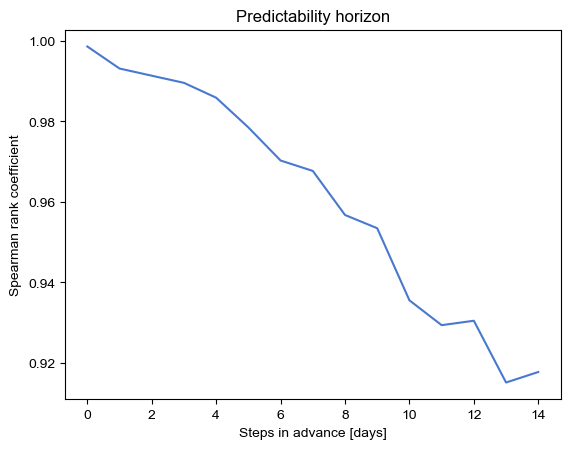

In [68]:

def get_predict_horizon(target_data,testPredict,testYind,predict_steps):
    testTarget = np.empty(np.shape(testPredict))
    for ii in range(len(testYind)):
        testTarget[ii,:] = target_data[testYind[ii]:testYind[ii] + predict_steps]
    #predict_horizon_R2 = [rsquared(testTarget[:,ii], testPredict[:,ii]) for ii in range(predict_steps)]
    predict_horizon = [spearman_lag(testTarget[:,ii], testPredict[:,ii], 0) for ii in range(predict_steps)]
    return predict_horizon

predict_horizon = get_predict_horizon(all_target_ts[target_ind], testPredict, testYind, predict_steps)

plt.figure()
plt.plot(np.arange(0,predict_steps), predict_horizon)
plt.title("Daily predictability horizon")
plt.ylabel("Spearman rank coefficient")
plt.xlabel("Steps in advance [days]")
plt.show()

predict_horizon_weekly = get_predict_horizon(all_target_ts[target_ind], testPredict, testYind, predict_steps)

plt.figure()
plt.plot(np.arange(0,predict_steps), predict_horizon_weekly)
plt.title("Weekly predictability horizon")
plt.ylabel("Spearman rank coefficient")
plt.xlabel("Steps in advance [weeks]")
plt.show()

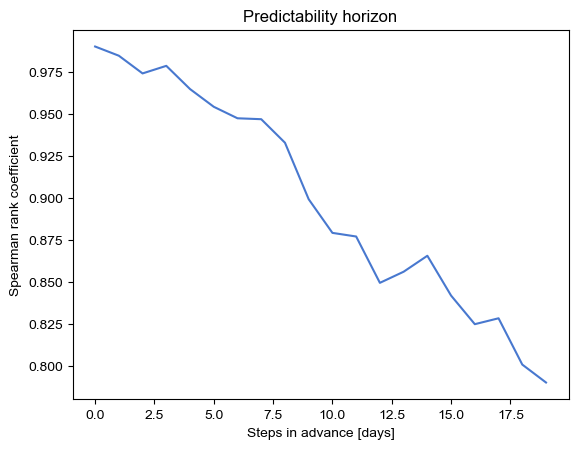